# AGU 2018 Demo

This notebook shows how to use `birdy`'s high-level interface to WPS processes. 

Here we access a test server called `Emu` offering a dozen or so dummy processes. 

## The shell interface

In [1]:
%%bash
export WPS_SERVICE=https://bovec.dkrz.de/ows/proxy/emu?Service=WPS&Request=GetCapabilities&Version=1.0.0
birdy -h

Usage: birdy [OPTIONS] COMMAND [ARGS]...

  Birdy is a command line client for Web Processing Services.

  Documentation is available on readthedocs:
  http://birdy.readthedocs.org/en/latest/

Options:
  --version         Show the version and exit.
  --cert TEXT       Client side certificate containing both certificate and
                    private key.
  -S, --send        Send client side certificate to WPS. Default: false
  -s, --sync        Execute process in sync mode. Default: async mode.
  -t, --token TEXT  Token to access the WPS service.
  -h, --help        Show this message and exit.

Commands:
  ultimate_question         Answer to the ultimate question: This process...
  sleep                     Sleep Process: Testing a long running...
  nap                       Afternoon Nap (supports sync calls only):...
  bbox                      Bounding box in- and out: Give bounding box,...
  hello                     Say Hello: Just says a friendly Hello.Returns...
  dummyprocess 

In [2]:
%%bash
birdy hello -h

Usage: birdy hello [OPTIONS]

  Say Hello: Just says a friendly Hello.Returns a literal string output with
  Hello plus the inputed name.

Options:
  --version    Show the version and exit.
  --name TEXT  Your name
  -h, --help   Show this message and exit.


In [3]:
%%bash
birdy hello --name stranger

ProcessSucceeded
Output:
output=['Hello stranger']


## The python interface

The `WPSClient` function creates a *mock* python module whose functions actually call a remote WPS process. The 
docstring and signature of the function are dynamically created from the remote's process description. If you type `wps.` and then press `Tab`, you should see a drop-down list of available processes. Simply call `help` on each process of type `?` after the process to print the docstring for that process. 


In [4]:
from birdy import WPSClient
url = "https://bovec.dkrz.de/ows/proxy/emu?Service=WPS&Request=GetCapabilities&Version=1.0.0"
wps = WPSClient(url)
help(wps.binaryoperatorfornumbers)

Help on method binaryoperatorfornumbers in module birdy.client.base:

binaryoperatorfornumbers(inputa=2.0, inputb=3.0, operator='add') method of birdy.client.base.WPSClient instance
    Performs operation on two numbers and returns the answer. This example process is taken from Climate4Impact.
    
    Parameters
    ----------
    inputa : //www.w3.org/TR/xmlschema-2/#float
        Enter Input 1
    inputb : //www.w3.org/TR/xmlschema-2/#float
        Enter Input 2
    operator : {'add', 'substract', 'divide', 'multiply'}//www.w3.org/TR/xmlschema-2/#string
        Choose a binary Operator
    
    Returns
    -------
    output : //www.w3.org/TR/xmlschema-2/#float
        Binary operator result



### Process execution

Processes are executed by calling the function. Each process instantaneoulsy returns a `WPSExecute` object. The actual output values of the process are obtained by calling the `get` method. This `get` method returns a namedtuple storing the process outputs as native python objects. 

In [5]:
resp = wps.binaryoperatorfornumbers(1, 2, operator='add')
print(resp)
resp.get()

binaryoperatorfornumbersResponse(
    output=3.0
)

For instance, the `inout` function returns a wide variety of data types (float, integers, dates, etc) all of which are converted into a corresponding python type. 

In [6]:
wps.inout().get()

inoutResponse(
    string='This is just a string',
    int=7,
    float=3.14,
    boolean=True,
    angle=90.0,
    time=datetime.time(12, 0),
    date=datetime.date(2012, 5, 1),
    datetime=datetime.datetime(2016, 9, 2, 12, 0, tzinfo=tzutc()),
    string_choice='scissor',
    string_multiple_choice='gentle albatros',
    text=ComplexDataInput(mimeType=None, encoding=None, schema=None, value='request didn&#39;t have a text file.'),
    dataset=ComplexDataInput(mimeType=None, encoding=None, schema=None, value='request didn&#39;t have a netcdf file.'),
    bbox=None
)

## Retrieving outputs by references

For `ComplexData` objects, WPS servers often return a reference to the output (an http link) instead of the actual data. This is useful if that output is to serve as an input to another process, so as to avoid passing back and forth large files for nothing. 

With `birdy`, the outputs are by default return values are the references themselves, but it's also possible to download these references in the background and convert them into python objects. To trigger this automatic conversion, set `asobj` to `True` when calling the `get` method. In the example below, we're using a dummy process called `output_formats`, whose first output is a netCDF file, and second output is a json file. With `asobj=True`, the netCDF file is opened and returned as a `netcdf4.Dataset` instance, and the json file into a dictionary. 

In [7]:
out = wps.output_formats()
nc, json = out.get()
print(out.get())
ds, json = out.get(asobj=True)
print(json)
ds

output_formatsResponse(
    netcdf='https://bovec.dkrz.de/download/outputs/emu/5d5abefe-fda2-11e8-b82b-109836a7cf3a/dummy.nc',
    json='https://bovec.dkrz.de/download/outputs/emu/5d5abefe-fda2-11e8-b82b-109836a7cf3a/dummy.json'
)
{'testing': [1, 2]}


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Test dataset
    dimensions(sizes): time(1)
    variables(dimensions): float64 time(time)
    groups: 

### Progress bar

It's possible to display a progress bar when calling a process. The interface to do so at the moment goes like this. Note that the cancel button does not do much here, as the WPS server does not support interruption requests. 

In [8]:
cli = WPSClient('http://cp4cds-cn1.dkrz.de/wps', progress=True)
response = cli.cmip5_regridder()

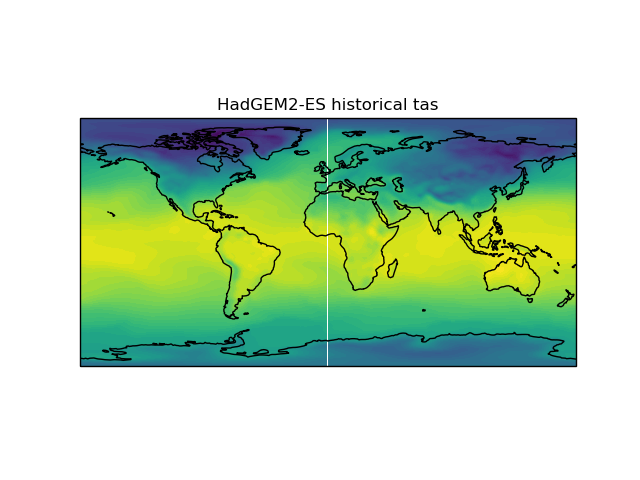

In [10]:
from IPython.display import Image
result = response.get()
Image(result.preview)